<a href="https://colab.research.google.com/github/Alina-Zakirova/equipment-failure-prediction/blob/main/%D0%9A%D0%BE%D0%BC%D0%B0%D0%BD%D0%B4%D0%B0_3_%22%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D1%83%D0%BC_%D0%9A%D0%B5%D0%B9%D1%81_7%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# **Кейс №7_Бинарная классификация отказов оборудования**

---


### **Описание задания:**
Нужно предсказать, произойдёт ли отказ оборудования на основе его технических характеристик, условий эксплуатации и истории работы

### **Ожидаемый результат:**
Обученная модель бинарной классификации, определяющая вероятность отказа оборудования

### **Основной функционал:**
- Импорт и анализ исторических данных;
- Предобработка и очистка данных;
- Обучение модели (SVM, деревья решений);
- Оценка метрик Precision, Recall, ROC-AUC.



# **0. Импорт необходимых библиотек**

In [1]:
!pip install kaggle
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [2]:
#Подготовка к работе с Kaggle API
from google.colab import files
import os

#Создадим загрузчик для файла kaggle.json через интерфейс Colab
files.upload()

#Создадим папку, в которую добавим наш файл и дадим права доступа
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving playground-series-s3e17.zip to playground-series-s3e17.zip
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


# **1. Знакомство с данными**

In [3]:
#Ссылка на источник данных
url = "https://www.kaggle.com/competitions/playground-series-s3e17/overview"
source_name = "PLAYGROUND PREDICTION COMPETITION · Binary Classification of Machine Failures"

html_link = f'''
<div style="margin: 10px; padding: 10px; background: #f0f8ff; border-radius: 5px;">
    <span style="font-size: 14px; color: #555;">🔗 Источник данных на Kaggle:</span>
    <a href="{url}" target="_blank" style="color: #1a73e8; text-decoration: none; font-weight: bold;">{source_name}</a>
</div>
'''

display(HTML(html_link))

In [4]:
#Загрузим данные напрямую из Kaggle, используя API нужных нам датасетов
!kaggle competitions download -c playground-series-s3e17

#Распаковываем архив c нашими данными
with zipfile.ZipFile('playground-series-s3e17.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

#Загружаем данные в переменную data_test и data_train
data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [5]:
#Проверка скачались ли наши файлы (архив) через API
!ls

playground-series-s3e17.zip  sample_submission.csv  train.csv
sample_data		     test.csv


## **Функция для вывода основной информации по датасету**
Будет использована и для тестовой, и для обучающей выборки


*P.S. Выведена отдельно, чтобы каждый член команды мог всегда ее найти*

In [6]:
def analyze_uniqueness(df):
    analysis = pd.DataFrame({
        'Тип данных': df.dtypes,
        'Всего значений': len(df),
        'Пропущенные значения': df.isnull().sum(),
        'Уникальные значения': df.nunique(),
        'Процент уникальности': (df.nunique() / len(df)) * 100
    })
    return analysis.sort_values('Уникальные значения', ascending=False)

## **1.1. Обучающая выборка**

In [7]:
data_train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [8]:
train_analysis = analyze_uniqueness(data_train)
display(train_analysis.style.background_gradient(cmap='coolwarm', subset=['Процент уникальности']))

,Тип данных,Всего значений,Пропущенные значения,Уникальные значения,Процент уникальности
id,int64,136429,0,136429,100.000000
Product ID,object,136429,0,9976,7.312228
Rotational speed [rpm],int64,136429,0,952,0.697799
Torque [Nm],float64,136429,0,611,0.447852
Tool wear [min],int64,136429,0,246,0.180314
Air temperature [K],float64,136429,0,95,0.069633
Process temperature [K],float64,136429,0,81,0.059372
Type,object,136429,0,3,0.002199
Machine failure,int64,136429,0,2,0.001466
TWF,int64,136429,0,2,0.001466


In [9]:
#Посмотрим внимательнее на уникальные значения для `Type`
data_train['Type'].unique()

array(['L', 'M', 'H'], dtype=object)

In [10]:
train_duplicates = data_train.duplicated().any()

if train_duplicates:
    print("В датасете есть дубликаты!")
    print(f"Общее количество дубликатов: {data_train.duplicated().sum()}")
else:
    print("Дубликатов не найдено")

Дубликатов не найдено


# **1.2. Тестовая выборка**

In [11]:
data_test.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [12]:
test_analysis = analyze_uniqueness(data_test)
display(test_analysis.style.background_gradient(cmap='coolwarm', subset=['Процент уникальности']))

,Тип данных,Всего значений,Пропущенные значения,Уникальные значения,Процент уникальности
id,int64,90954,0,90954,100.000000
Product ID,object,90954,0,9909,10.894518
Rotational speed [rpm],int64,90954,0,946,1.040086
Torque [Nm],float64,90954,0,595,0.654177
Tool wear [min],int64,90954,0,246,0.270466
Air temperature [K],float64,90954,0,92,0.101150
Process temperature [K],float64,90954,0,84,0.092354
Type,object,90954,0,3,0.003298
TWF,int64,90954,0,2,0.002199
HDF,int64,90954,0,2,0.002199


In [13]:
test_duplicates = data_test.duplicated().any()

if test_duplicates:
    print("В датасете есть дубликаты!")
    print(f"Общее количество дубликатов: {data_test.duplicated().sum()}")
else:
    print("Дубликатов не найдено")

Дубликатов не найдено


### **Данные**

Обучающая и тестовая выборки заданы заранее:

- **train.csv - обучающая выборка**
  - Содержит 136429 значений;
  - Не содержит пропусков;
  - Не содержит дубликатов.

- **test.csv - тестовая выборка**
  - Содержит 90954 значения;
  - Не содержит пропусков;
  - Не содержит дубликатов.
---

### **Описание столбцов:**
- **id** - идентификатор записи в датасете;

- **Product ID** - уникальный номер экземпляра оборудования/машины. Состоит из буквы (L/M/H, которая обозначает качество машины) и серийного номера;

***На подумать:*** так как не все айдишники продуктов уникальные, делаем выводы, что наблюдаем за 1 и тем же набором 9976 машин. Скорее всего у нас дана информация за n-ный временной период, и можно поискать зависимости, с какого наблюдения машины начинают ломаться/есть ли случаи, когда 1 тип ошибки ведет за собой какой-то 2 и т.д. Именно по этой причине я не стала удалять просто айдишники записей, возможно, их можно будет поранжировать.

- **Rotational speed [rpm]** - частота вращения машины (оборотов в минуту);

- **Torque [Nm]** - крутящий момент (Ньютон-метров);

- **Tool wear [min]** - износ оборудования (минут); сколько минут работало оборудование). Чем выше качество оборудования (Type), тем дольше оно может работать в рамках 1 запуска;

- **Air temperature [K]** - температура воздуха в кельвинах;

- **Process temperature [K]**- температура процесса в кельвинах.
Формула расчета: температура воздуха + 10K;

- **Type** - обозначает качество конкретного экземпляра оборудования и влияет на его износ:
  - H - высокое (+5 минут),
  - M - среднее (+3 минуты),
  - L - низкое (+2 минуты);

- **Machine failure** - отображает факт ошибки в работе оборудования: 0 - ошибки нет, 1 - ошибка есть.

**Возможные ошибки/неисправности/причины поломки:**
- **TWF** - tool wear failure, неисправность из-за износа оборудования
  - Оборудование заменяется или выходит из строя при износе 200-240 минут;

- **HDF** - heat dissipation failure, неисправность из-за нарушения теплоотдачи. Возникает, если:
  - Разница между температурой процесса и воздуха < 8.6K,
  - Скорость вращения < 1380 об/мин;

- **PWF** - power failure, неисправность из-за недостатка мощности (крутящего момента)
  - Отказ, если мощность (крутящий момент × скорость) выходит за пределы 3500-9000 Вт;

- **OSF** - неисправность из-за перенапряжения. Отказ при превышении порога:
  - L: (износ × крутящий момент) > 11000 мин×Нм,
  - M: > 12000 мин×Нм,
  - H: > 13000 мин×Нм;

- **RNF**	- random failures, случайная неисправность. Вероятность отказа 0.1% независимо от параметров.

**ВАЖНО:** Если хотя бы одна из вышеперечисленных ошибок имеет значение true, работа оборудования завершается сбоем, метке "Machine failure" присваивается значение 1

***Подробнее о данных можно прочитать [ЗДЕСЬ](https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020)***


---

### **Цель:**
Предсказать **вероятность** выхода оборудования из строя (ошибка/отказ оборудования)

=> **Целевой признак:** `Machine Failure`

# **1.3 Распределение ошибок для каждого типа оборудования**

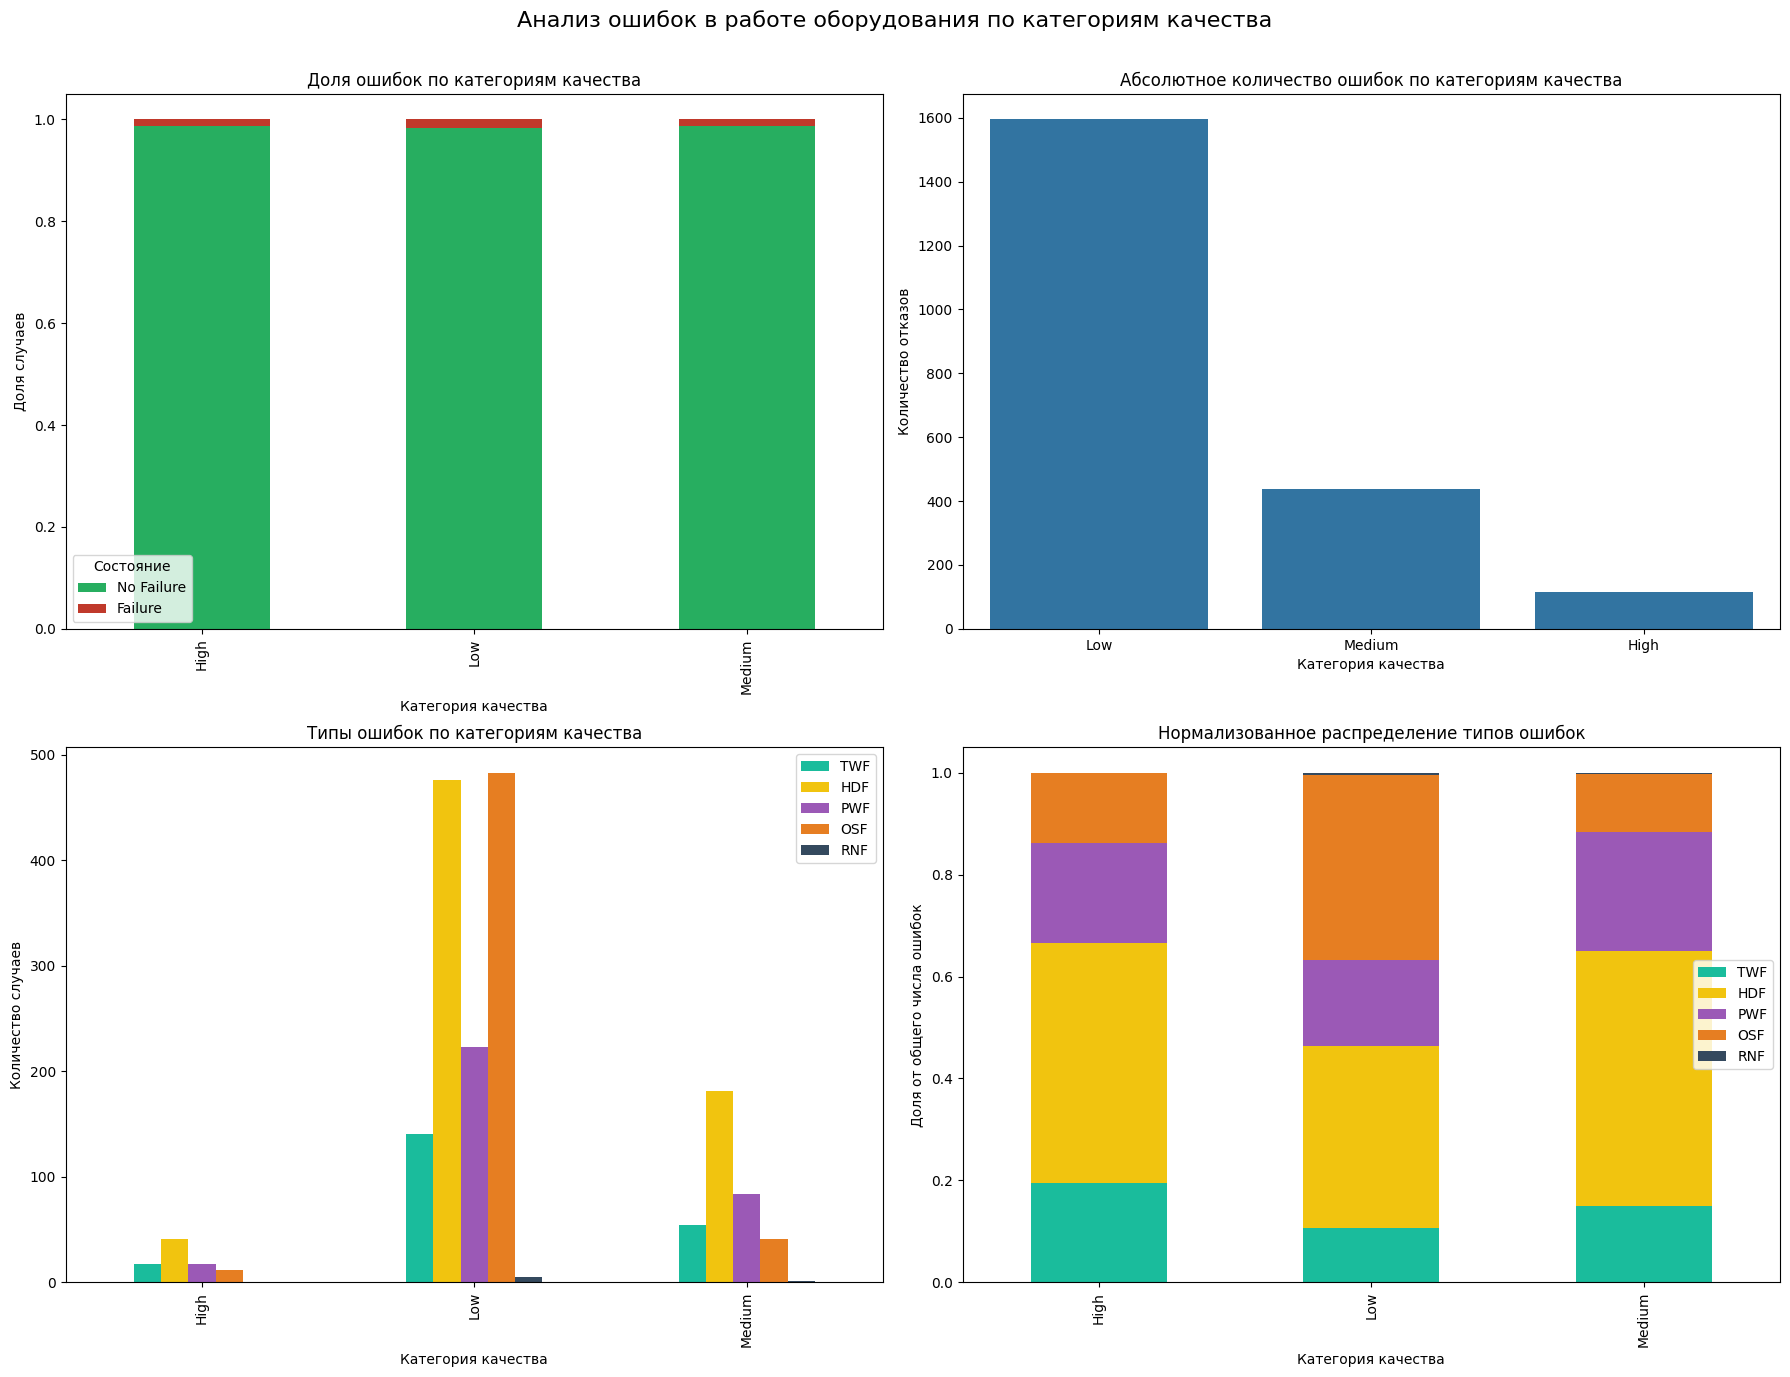


1. Доля ошибок по категориям качества:


Machine failure,No Failure,Failure
quality,,
High,0.987000,0.013000
Low,0.983273,0.016727
Medium,0.986408,0.013592



2. Абсолютное количество ошибок:


,Количество ошибок
quality,
Low,1595
Medium,437
High,116



3. Распределение типов ошибок:


,TWF,HDF,PWF,OSF,RNF
quality,,,,,
High,17,41,17,12,0
Low,141,476,223,483,5
Medium,54,181,84,41,1



4. Нормализованное распределение типов ошибок:


,TWF,HDF,PWF,OSF,RNF
quality,,,,,
High,0.195402,0.471264,0.195402,0.137931,0.000000
Low,0.106175,0.358434,0.167922,0.363705,0.003765
Medium,0.149584,0.501385,0.232687,0.113573,0.002770


In [14]:
# 1. Определяем категорию качества на основании столбца "Type" нашего датасета
data_train['quality'] = data_train['Type'].map({'L': 'Low', 'M': 'Medium', 'H': 'High'})

# 2. Посмотрим на распределение оошибок по категориям качества
failure_distribution = pd.crosstab(data_train['quality'], data_train['Machine failure'], normalize='index').rename(columns={0: 'No Failure', 1: 'Failure'})

# 3. Посмотрим на абсолютное количество ошибок по каждой категории качества
absolute_failures = data_train[data_train['Machine failure'] == 1]['quality'].value_counts()

# 4. Распределение типов ошибок по категориям качества
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_types_dist = data_train[data_train['Machine failure'] == 1].groupby('quality')[failure_modes].sum()

# ВИЗУАЛИЗАЦИЯ
# Чтобы "не плодить" графики, выведем 4 графика в рамках 1 фигуры
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Анализ ошибок в работе оборудования по категориям качества', fontsize=16)

# График 1: Доля ошибок по категориям качества
failure_distribution.plot(kind='bar', stacked=True, ax=axes[0,0], color=['#27ae60', '#c0392b'])
axes[0,0].set_title('Доля ошибок по категориям качества')
axes[0,0].set_ylabel('Доля случаев')
axes[0,0].set_xlabel('Категория качества')
axes[0,0].legend(title='Состояние')

# График 2: Абсолютное количество ошибок
sns.barplot(x=absolute_failures.index, y=absolute_failures.values, ax=axes[0,1])
axes[0,1].set_title('Абсолютное количество ошибок по категориям качества')
axes[0,1].set_ylabel('Количество отказов')
axes[0,1].set_xlabel('Категория качества')

# График 3: Типы ошибок по категориям качества
failure_types_dist.plot(kind='bar', ax=axes[1,0], color=['#1abc9c', '#f1c40f', '#9b59b6', '#e67e22', '#34495e'])
axes[1,0].set_title('Типы ошибок по категориям качества')
axes[1,0].set_ylabel('Количество случаев')
axes[1,0].set_xlabel('Категория качества')

# График 4: Нормализованное распределение типов ошибок
#какой % каждый тип ошибки занимает в общем количестве ошибок для конкретной категории оборудования.
(failure_types_dist.div(failure_types_dist.sum(axis=1), axis=0)).plot(kind='bar',
                                                                    stacked=True,
                                                                    ax=axes[1,1],
                                                                    color=['#1abc9c', '#f1c40f', '#9b59b6', '#e67e22', '#34495e'])
axes[1,1].set_title('Нормализованное распределение типов ошибок')
axes[1,1].set_ylabel('Доля от общего числа ошибок')
axes[1,1].set_xlabel('Категория качества')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Для любителей аналитики в табличном виде <3
# Вывод таблиц с данными
print("\n1. Доля ошибок по категориям качества:")
display(failure_distribution.style.background_gradient(cmap='Set2', subset=['Failure']))

print("\n2. Абсолютное количество ошибок:")
display(absolute_failures.to_frame('Количество ошибок').style.background_gradient(cmap='Set2'))

print("\n3. Распределение типов ошибок:")
display(failure_types_dist.style.background_gradient(cmap='Set2'))

print("\n4. Нормализованное распределение типов ошибок:")
display(failure_types_dist.div(failure_types_dist.sum(axis=1), axis=0).style.background_gradient(cmap='Set2'))

## **Промежуточный вывод об ошибках для каждого типа оборудования**

### **Общая частота ошибок:**
Несмотря на различия в распространенных ошибках для оборудования разного качества, общая доля ошибок для всех категорий находится в диапазоне 1.3-1.7%, что указывает на:
- Высокую надежность оборудования независимо от его категории (L/M/H);
- Эффективность системы предупреждения ошибок;
- Low-оборудование имеет незначительно повышенную частоту ошибок (1.67% vs 1.3-1.36% для High/Medium), что обуславливает его "популярность" на фоне оборудования среднего и высокого качества (50% от общего количества).

**Случайные ошибки (RNF):**
- Не встречаются в высококачественном оборудовании (0%),
- Имеют минимальные значения для Low (0.38%) и Medium (0.28%), что в целом соответствует заявленной вероятности в 0.1%.

### **Абсолютные показатели:**
**Преобладание ошибок в Low-категории** (1595 случаев) объясняется:
- Большим количеством такого оборудования в эксплуатации (50% от общего числа)
- Более высокой склонностью к перегрузкам (OSF - 483 случая)
- Проблемами с теплоотведением (HDF - 30%)

**Medium-оборудование** (437 случаев):

Для Medium-качества лидирует HDF (50.1%), но с заметной долей PWF (Power Failure - 23.3%).

**High-оборудование** (116 случаев):

Для оборудования High-качества основной причиной отказов является HDF (Heat Dissipation Failure - 47.1%), что почти в 2 раза чаще, чем другие типы. Это может указывать на проблемы с теплоотведением при интенсивной эксплуатации дорогостоящего оборудования.


---

## **Следующий шаг для проведения анализа:**

Выясним, какие значения являются критическими для возникновения ошибок.
Так, например, для высококачественного оборудования основная проблема - теплоотведение. Выявим, какая температура является причиной поломки.



## **Функция для определения критических значений отдельных параметров, которые приводят к возникновению ошибок**

**Ее суть** - определение критических порогов (1.5*IQR для выбросов) в параметрах, которые являются причиной возникновения ошибки
Так, например, для OSF критическими являются: крутящий момент и износ инструмента:
1. Выберем кейсы, которые соответстуют следующей логике:
  - Тип оборудования = L,
  - Ошибка = OSF,
  - Наличие ошибки = да
2. Найдем те значения параметров, достижение которых ВСЕГДА приводит к ошибке

*P.S. Выведена отдельно, чтобы каждый член команды мог всегда ее найти*

In [15]:
# Cоздадим функцию analyze_critical_values(df)

def analyze_critical_values(df):
    # Создаем словарь для хранения критических значений для самых популярных ошибок
    critical_values = {
        'High': {'Failure': 'HDF', 'Metrics': ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]']},
        'Medium': {'Failure': 'HDF', 'Metrics': ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]']},
        'Low': {'Failure': 'OSF', 'Metrics': ['Torque [Nm]', 'Tool wear [min]']}
    }

    df['Quality'] = df['Type'].map({'L': 'Low', 'M': 'Medium', 'H': 'High'})

    results = {}

    for quality in ['High', 'Medium', 'Low']:
        failure_type = critical_values[quality]['Failure']
        metrics = critical_values[quality]['Metrics']

        # Фильтруем данные для текущего типа оборудования с нужным нам типом ошибки
        failure_data = df[(df['Quality'] == quality) & (df[failure_type] == 1)]

        # Анализируем критические параметры
        analysis = {}
        for metric in metrics:
            stats = failure_data[metric].describe(percentiles=[0.05, 0.25, 0.75, 0.95])
            analysis[metric] = {
                'mean': stats['mean'],
                'median': stats['50%'],
                '5th_percentile': stats['5%'],
                '95th_percentile': stats['95%'],
                'critical_threshold': stats['75%'] + 1.5*(stats['75%'] - stats['25%'])  # Правило 1.5*IQR для выбросов
            }

        results[quality] = {
            'failure_type': failure_type,
            'critical_params': analysis
        }

        # Визуализация: ящики с усами для наглядного определения критических значений
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Критические значения параметров для {quality}-качества (Ошибка {failure_type})', y=1.02)

        for i, metric in enumerate(metrics, 1):
            plt.subplot(1, len(metrics), i)
            sns.boxplot(x=failure_data[metric])
            plt.axvline(analysis[metric]['critical_threshold'], color='r', linestyle='--')
            plt.title(metric)
            plt.xlabel('Значение')

        plt.tight_layout()
        plt.show()

    return results

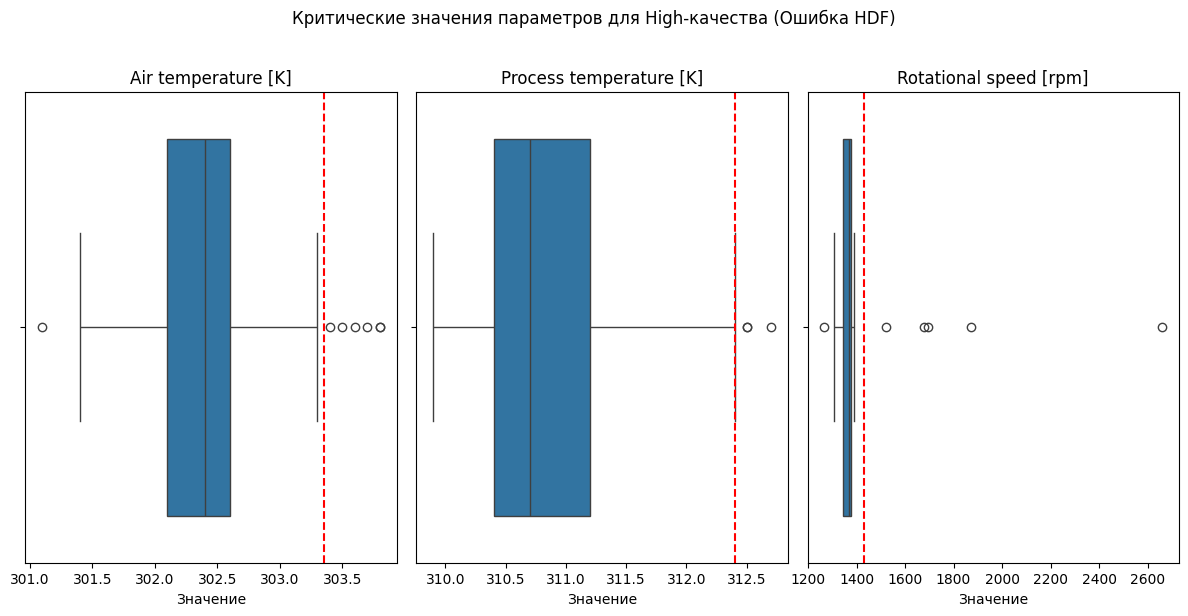

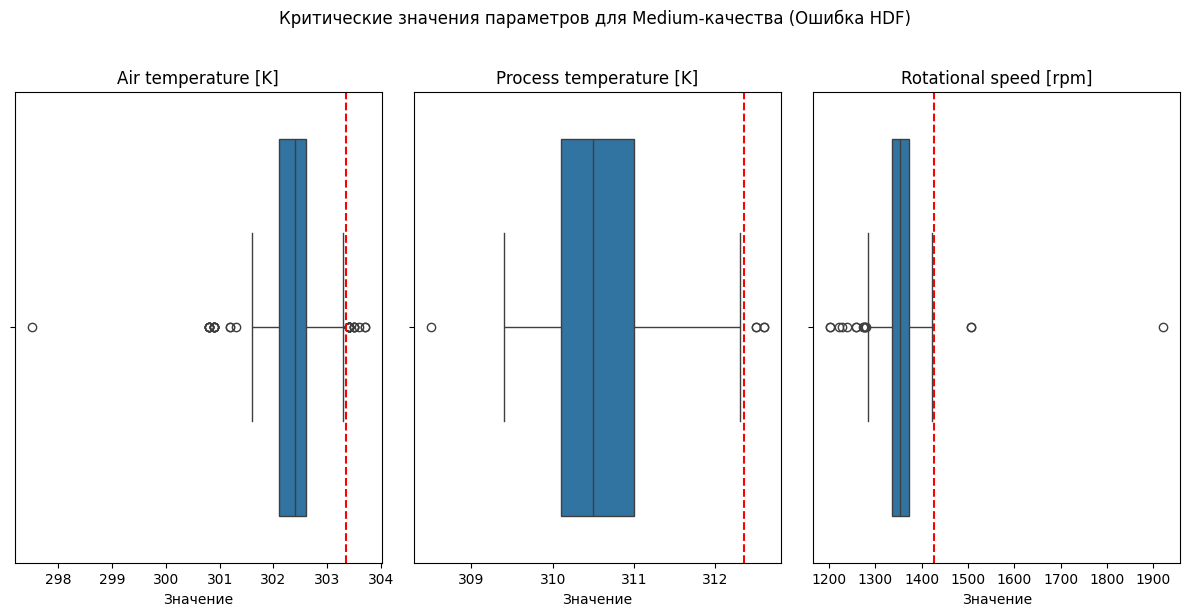

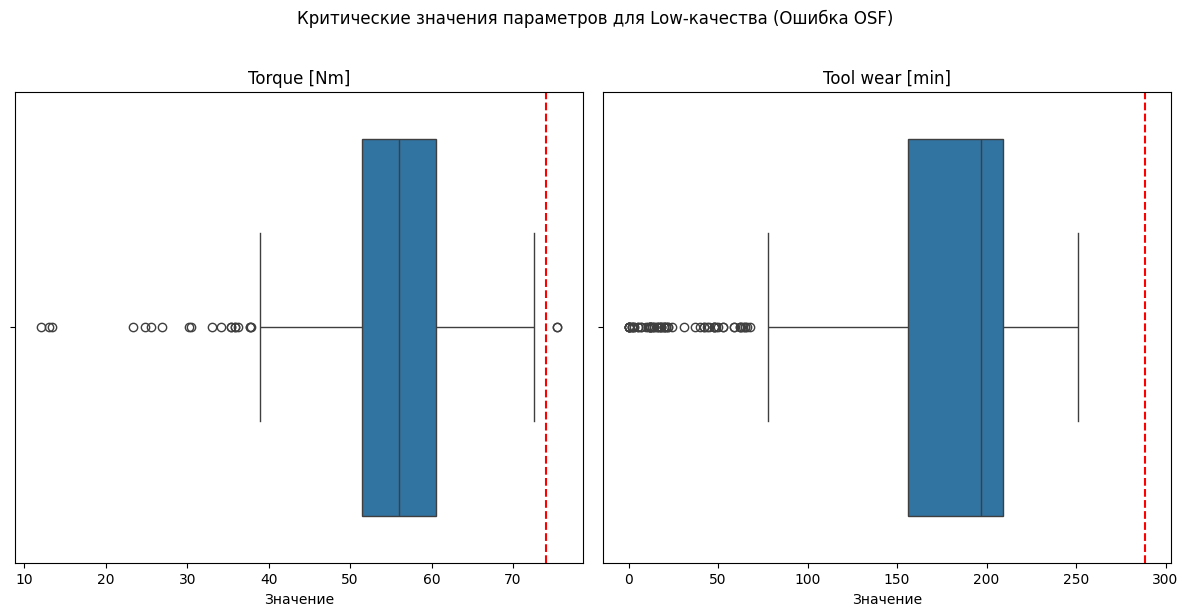


=== High-качество ===
Основная ошибка для оборудования High-качества: HDF


,mean,median,5th_percentile,95th_percentile,critical_threshold
Air temperature [K],302.478049,302.400000,301.700000,303.700000,303.350000
Process temperature [K],310.887805,310.700000,310.100000,312.500000,312.400000
Rotational speed [rpm],1420.146341,1368.000000,1313.000000,1694.000000,1430.000000



=== Medium-качество ===
Основная ошибка для оборудования Medium-качества: HDF


,mean,median,5th_percentile,95th_percentile,critical_threshold
Air temperature [K],302.326882,302.400000,300.900000,303.400000,303.350000
Process temperature [K],310.611828,310.500000,309.400000,311.900000,312.350000
Rotational speed [rpm],1350.682796,1353.000000,1276.500000,1393.500000,1427.500000



=== Low-качество ===
Основная ошибка для оборудования Low-качества: OSF


,mean,median,5th_percentile,95th_percentile,critical_threshold
Torque [Nm],55.106776,56.000000,40.960000,66.340000,74.000000
Tool wear [min],169.036961,197.000000,14.000000,228.000000,288.500000


In [16]:
# Воспользуемся написанной функцией
critical_analysis = analyze_critical_values(data_train)

# Для любителей аналитики в табличном виде <3
# Вывод таблиц с данными
for quality, data in critical_analysis.items():
    print(f"\n=== {quality}-качество ===")
    print(f"Основная ошибка для оборудования {quality}-качества: {data['failure_type']}")

    df = pd.DataFrame(data['critical_params']).T
    display(df.style.background_gradient(cmap='Set2', subset=['critical_threshold']))

## **Итоговый вывод по ошибкам для каждого типа оборудования**

### **1. Оборудование High Quality (высокий класс)**

**Основная проблема:** Отказы из-за перегрева (HDF)

**Критические параметры:**
- Температура воздуха:
  - Превышение 303.35K (критический порог) значительно увеличивает риск отказа.
  - 95% отказов происходят при температуре до 303.7K, но системные сбои начинаются уже после 303.35K.

- Температура процесса:
  - Критическое значение — 312.4K.
  - Средняя температура при отказах — 310.89K, но пиковые значения (>312.5K) особенно опасны.

- Скорость вращения:
  - Превышение 1430 rpm ведет к повышенному риску.
  - В 95% случаев отказы происходят при скорости до 1694 rpm, но устойчивая работа нарушается уже после 1430 rpm.

### **2. Оборудование Medium Quality (средний класс)**

**Основная проблема:** Отказы из-за перегрева (HDF)

**Критические параметры:**
- Температура воздуха:
  - Риск отказа резко возрастает после 303.35K.
  = 95% отказов происходят при до 303.4K, но критический порог близок к этому значению.
- Температура процесса:
  - Критический порог — 312.35K.
  - Среднее значение при отказах — 310.61K, но опасны скачки выше 311.9K.
- Скорость вращения:
  - Превышение 1427.5 rpm — зона риска.
  - В 95% случаев отказы фиксируются при до 1393.5 rpm, но критические значения начинаются раньше.

### **3. Оборудование Low Quality (низкий класс)**

**Основная проблема:** Отказы из-за перегрузок (OSF)

**Критические параметры:**
- Крутящий момент:
  - Критическое значение — 74 Nm, но 95% отказов происходят уже при 66.34 Nm.
  - Среднее значение момента при отказах — 55.1 Nm, что указывает на повышенный износ при длительных нагрузках.
- Износ инструмента:
  - Критический порог — 288.5 мин, но 95% отказов случаются до 228 мин.
  - Медианное значение при отказах — 197 мин, что говорит о необходимости замены инструмента до 200 мин.

## **Кодирование категориальных признаков**

**Категориальный признак в нашем датасете — это Type (L, M, H).**

 Для него лучше применить One-Hot Encoding, так как это номинальная переменная без порядка. One-Hot Encoding создаст три новых бинарных признака (Type_L, Type_M, Type_H), что поможет моделям лучше интерпретировать данные.

In [17]:
# One-Hot Encoding для признака 'Type'
data_train = pd.get_dummies(data_train, columns=['Type'], prefix='Type')
data_test = pd.get_dummies(data_test, columns=['Type'], prefix='Type')

# Проверка результата
print(data_train.head())

   id Product ID  Air temperature [K]  Process temperature [K]  \
0   0     L50096                300.6                    309.6   
1   1     M20343                302.6                    312.1   
2   2     L49454                299.3                    308.5   
3   3     L53355                301.0                    310.9   
4   4     M24050                298.0                    309.0   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1596         36.1              140                0    0   
1                    1759         29.1              200                0    0   
2                    1805         26.5               25                0    0   
3                    1524         44.3              197                0    0   
4                    1641         35.4               34                0    0   

   HDF  PWF  OSF  RNF quality Quality  Type_H  Type_L  Type_M  
0    0    0    0    0     Low     Low   False    Tru

## **Нормализация числовых признаков**

Числовые признаки (например, Air temperature [K], Rotational speed [rpm] и др.) имеют разные масштабы. Для их нормализации выберем **StandardScaler**, который преобразует данные так, чтобы их распределение имело среднее 0 и стандартное отклонение 1. Это особенно полезно для алгоритмов, чувствительных к масштабу (например, SVM).

In [18]:
from sklearn.preprocessing import StandardScaler

# Выбираем числовые признаки для нормализации
numeric_features = ['Air temperature [K]', 'Process temperature [K]',
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Инициализация StandardScaler
scaler = StandardScaler()

# Применяем нормализацию к обучающей и тестовой выборкам
data_train[numeric_features] = scaler.fit_transform(data_train[numeric_features])
data_test[numeric_features] = scaler.transform(data_test[numeric_features])

# Проверка результата
print(data_train[numeric_features].head())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.395880                -0.246230                0.545416   
1             1.469856                 1.558605                1.720308   
2            -0.302204                -1.040358                2.051873   
3             0.610675                 0.692284                0.026445   
4            -1.000288                -0.679391                0.869773   

   Torque [Nm]  Tool wear [min]  
0    -0.499711         0.556417  
1    -1.323028         1.494433  
2    -1.628831        -1.241447  
3     0.464745         1.447532  
4    -0.582043        -1.100744  


## **Выводы: Основные особенности данных, важные для модели**
**1. Распределение ошибок по типам оборудования:**

- Low-качество (L): Наиболее частые отказы (1.67%), основные причины — перегрузки (OSF, 36.4%) и проблемы с теплоотведением (HDF, 35.8%).

- Medium-качество (M): Отказы реже (1.36%), доминирует HDF (50.1%).

- High-качество (H): Наименьшее количество отказов (1.3%), основная проблема — HDF (47.1%).

**2. Критические параметры для отказов:**

- High/Middle (HDF):

  - Температура воздуха: >303.35K (High), >303.35K (Medium).

  - Температура процесса: >312.4K (High), >312.35K (Medium).

  - Скорость вращения: >1430 rpm (High), >1427.5 rpm (Medium).

- Low (OSF):

  - Крутящий момент: >74 Nm (критический порог), но 95% отказов уже при >66.34 Nm.

  - Износ инструмента: >288.5 мин (критический порог), но 95% отказов до 228 мин.

**3. Дисбаланс классов:**

Целевой признак Machine failure сильно несбалансирован: только ~1.5% случаев — отказы. Необходимо применить методы балансировки (например, SMOTE) или использовать взвешенные метрики.